# План домашних заданий


- Описание задачи и знакомство с данными
- Домашнее задание 1. Генерация и фильтрация признаков
- Домашнее задание 2. Прогноз времени и вида поломки машин, настройка ML-модели
- Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков
- Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`
- Домашнее задание 4. Блендинг
- Домашнее задание 5. Парсинг внешних данных и оптимизация памяти
- Отправка финального решения на лидерборд на Kaggle

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# <center id="part0"> Описание задачи

**Предыстория:**  мы работаем с каршеринговой компанией, которая управляет крупным автопарком машин. Наша цель — предотвратить длительные периоды простоя машин из-за поломок через своевременное обслуживание и ремонт.


**Идея для решения проблемы:** создать приоритизированный список обхода машин. Этот список поможет технической бригаде сосредоточиться на автомобилях, которые наиболее вероятно выйдут из строя в ближайшее время.


**Как компания решает задачу:**

* Собирает данные о поездках и состоянии машин до поломок.

* Нанимает Data Scientist, чтобы он смог использовать эти данные для анализа и прогнозирования характера поломок.

**Важный момент**: задачи этого специалиста (Data Scientist) предстоит выполнять вам.

## <center> Знакомство с данными

### Информация про машины с таргетом (основной датасет)

In [2]:
car_train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv')
car_train.sample(5)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
2190,D-6635489N,Renault Sandero,standart,petrol,7.76,2013,51693,2015,40.13,break_bug
206,a-8546767B,VW Polo VI,economy,petrol,5.64,2012,20652,2014,53.85,engine_check
329,K20554631n,Nissan Qashqai,standart,petrol,3.66,2011,2783,2020,48.28,electro_bug
2113,M-3227100t,VW Polo,economy,petrol,5.02,2012,21148,2016,51.42,engine_overheat
967,w75295475d,Kia Rio,economy,petrol,3.62,2011,2985,2021,25.31,engine_fuel


- `car_id` — идентификатор машины
- `model` / `car_type` / `fuel_type` — марка, класс и тип топлива машины
- `car_rating` / `riders` — общий рейтинг и общее число поездок к концу 2021 года
- `year_to_start` / `year_to_work` — год выпуска машины и год начала работы в автопарке
- `target_reg` — количество дней до поломки
- `target_class` — класс поломки (всего 9 видов)

### Информация про поездки

In [3]:
rides_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/rides_info.csv')
rides_info.sample(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
275882,G48658096X,T-2050577H,E1z,2020-02-18,1.25,55,600,48,157.674528,0,2539.292362,0,-5.322047,-23.486
108600,o23593659z,H29930196K,e1l,2020-01-13,5.56,4056,64890,49,70.000000,2,201375.673517,0,-2.702188,-0.182
717310,U22306237o,y12023699E,G1q,2020-02-13,2.83,24,379,47,53.000000,0,1181.987855,0,7.198470,-22.310
258046,f41244517M,S-1058341S,a1W,2020-01-03,6.40,66,787,53,78.225489,0,2772.798123,0,2.985129,-0.000
203792,r15305819f,O-4279569M,q1W,2020-01-21,3.18,49,778,56,68.000000,0,2636.997604,0,2.240445,-0.001


- `user_id` / `car_id` / `ride_id` — идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` — дата поездки и рейтинг, поставленный водителем
- `ride_duration` / `distance` / `ride_cost` —  длительность (время),  пройденное расстояние, стоимость поездки
- `speed_avg` / `speed_max` — средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` — количество остановок (паузы) и флаг: была ли дозаправка
- `user_ride_quality` — оценка манеры вождения водителя машины, определенная скоринговой ML-системой сервиса
- `deviation_normal` — общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы)

### Информация про водителей

In [4]:
driver_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/driver_info.csv')
driver_info.sample(5)

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
321,18,8.2,335,16.0,V17551179M,1,2019-8-18
2822,44,7.1,561,7.0,s21764921v,0,2019-6-19
14403,18,8.1,1882,17.0,v21038297c,1,2018-4-10
8311,22,6.8,1113,1.0,D28263772N,1,2018-10-28
2523,31,7.0,898,9.0,S13957300s,1,2019-3-21


- `user_id` / `age` / `sex` — идентификатор, возраст и пол водителя, соответственно
- `user_rating` — общий рейтинг пользователя за все поездки к концу 2021 года
- `user_rides` — общее количество поездок к концу 2021 года
- `user_time_accident` — число инцидентов (это могли быть аварии/штрафы/эвакуация машины)  
- `first_ride_date` — дата первой поездки

### Информация про ремонт машин

In [5]:
fix_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/fix_info.csv')
fix_info.sample(5)

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
68549,L-4889905g,MB,2020-5-24 22:52,repair,4.3,8
119894,Y-1015822T,RS,2019-4-8 5:49,refuel_check,1.0,22
61192,l-2073691v,PC,2019-3-13 6:22,repair,4.4,8
123719,s-4342091J,HH,2019-5-24 13:53,repair,8.0,35
73881,k-2273981K,JK,2019-8-13 20:11,repair,4.1,2


- `worker_id` / `car_id` — идентификатор работника и машины
- `work_type` / `work_duration` — тип и длительность (в часах) проводимой работы
- `destroy_degree` — степень износа/поврежденности машины в случае поломки
- `fix_date` — время начала ремонта (снятия машины с линии)

# Домашнее задание 1. Генерация и фильтрация признаков

<center> <img src="https://ucarecdn.com/bf4c772d-b67a-42ae-a48b-cfd83910b0a2/" width=700>

<div class="alert alert-info">

**Цель блока** — сгенерировать признаки из дополнительных датасетов и добавить их к основному датасету, произвести фильтрацию признаков.

    
## Задание 1. Генерация признаков из дополнительных датасетов (6 баллов)

<div class="alert alert-info">

1. Возьмите датасет `rides_info` с информацией о поездках и проведите группировку по каждой машине отдельно.

2. Для каждой машины (то есть для каждого `car_id`) подсчитайте несколько признаков:
  - минимальный рейтинг за все поездки;
  - средний рейтинг за все поездки;
  - общее количество километров, которое машина проехала;
  - максимальная скорость;
  - общее количество поездок для каждой машины.

3. Добавьте минимум 3 признака на свой выбор.

4. Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

5. Подключите информацию про водителей (`driver_info`) и про ремонт машин (`fix_info`). Добавьте минимум 3 любых признака с каждого датасета.


<h4> Критерии оценивания </h4>
    
- Добавлены 5 обязательных и минимум 3 любых признака из датасета `rides_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `driver_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `fix_info` — 2 балла.

</div>

<div class="alert alert-success">
    
<h4> Советы по Feature Engineering</h4>
    
- Начинайте с сырых данных.
- Используйте все доступные данные. Покрывайте признаками всю имеющуюся информацию в данных.
- Формулируйте предположения: от чего зависит таргет?
- Смотрите визуально на классы/ошибки и делайте предположения. Какие полезны?
- Помните, что слишком много признаков может быть вредно. Потом придется отфильтровывать.
    
<h4> Полезные источники </h4>
    
- Занятие про Feature Engineering.
- Занятие про Feature Selection.
- [Max Kuhn and Kjell Johnson. Feature Engineering and Selection: A Practical Approach for Predictive Models](http://www.feat.engineering/).

## **Решение 1 задания**

### Для каждой машины (то есть для каждого car_id) подсчитайте несколько признаков:

- минимальный рейтинг за все поездки;
- средний рейтинг за все поездки;
- общее количество километров, которое машина проехала;
- максимальная скорость;
- общее количество поездок для каждой машины.

In [6]:
group_of_rides = rides_info.groupby('car_id', as_index=False).agg(
    min_rating = ('rating', 'min'),
    mean_rating = ('rating', 'mean'),
    sum_distance = ('distance', 'sum'),
    speed_max = ('speed_max', 'max'),
    count_rides = ('ride_id', 'count')
)

In [7]:
group_of_rides.head()

,car_id,min_rating,mean_rating,sum_distance,speed_max,count_rides
0,A-1049127W,0.1,4.255172,1.125753e+07,179.729652,174
1,A-1079539w,0.1,4.088046,1.912765e+07,184.505566,174
2,A-1162143G,0.1,4.662299,2.995194e+06,180.000000,174
3,A-1228282M,0.1,4.225172,1.793685e+07,182.446070,174
4,A-1339912r,0.1,4.690115,1.202552e+07,152.000000,174


### Добавьте минимум 3 признака на свой выбор.

In [8]:
group_of_rides = rides_info.groupby('car_id', as_index=False).agg(
    min_rating = ('rating', 'min'),
    mean_rating = ('rating', 'mean'),
    sum_distance = ('distance', 'sum'),
    speed_max = ('speed_max', 'max'),
    count_rides = ('ride_id', 'count'),

    speed_mean = ('speed_avg', 'mean'),
    user_ride_quality_max = ('user_ride_quality', 'max'),
    ride_cost_mean = ('ride_cost', 'mean'),
)

In [9]:
group_of_rides.head()

,car_id,min_rating,mean_rating,sum_distance,speed_max,count_rides,speed_mean,user_ride_quality_max,ride_cost_mean
0,A-1049127W,0.1,4.255172,1.125753e+07,179.729652,174,49.459770,8.556052,15201.436782
1,A-1079539w,0.1,4.088046,1.912765e+07,184.505566,174,49.591954,19.324837,27007.477011
2,A-1162143G,0.1,4.662299,2.995194e+06,180.000000,174,43.448276,10.915018,4599.678161
3,A-1228282M,0.1,4.225172,1.793685e+07,182.446070,174,49.379310,4.188281,27379.522989
4,A-1339912r,0.1,4.690115,1.202552e+07,152.000000,174,44.149425,1.038861,16185.545977


### Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

In [10]:
df = pd.merge(car_train, group_of_rides, on='car_id')

In [11]:
df.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,min_rating,mean_rating,sum_distance,speed_max,count_rides,speed_mean,user_ride_quality_max,ride_cost_mean
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,0.1,4.737759,1.214131e+07,180.855726,174,44.660920,11.035871,20106.873563
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,0.0,4.480517,1.803909e+07,187.862734,174,49.862069,32.610351,26813.614943
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,0.1,4.768391,1.588366e+07,102.382857,174,44.005747,11.766087,23987.793103
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,0.1,3.880920,1.651883e+07,172.793237,174,49.344828,3.931040,37839.086207
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,0.1,4.181149,1.398317e+07,203.462289,174,50.603448,3.344463,19888.431034


### Подключите информацию про водителей (driver_info) и про ремонт машин (fix_info). Добавьте минимум 3 любых признака с каждого датасета.

In [154]:
df = pd.merge(df, rides_info, on='car_id')

In [155]:
df.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,rating,ride_duration,ride_cost,speed_avg,speed_max_y,stop_times,distance,refueling,user_ride_quality,deviation_normal
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,5.72,220,3514,42,NaN,6,1.682556e+03,0,0.524750,0.0
1,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,2.52,37392,523483,45,53.000000,2,1.711379e+06,0,1.723151,0.0
2,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,7.17,45,444,54,82.000000,0,9.523155e+02,0,0.876440,-0.0
3,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,6.19,10,105,35,40.000000,0,2.372539e+02,0,1.274242,-0.0
4,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,3.14,49,486,54,85.845615,1,1.837067e+03,0,0.952363,-0.0


In [ ]:
df = pd.merge(df, driver_info[['user_id', 'age', 'user_rides']], on='user_id')

In [ ]:
df = pd.merge(df, driver_info[['user_id', 'user_rating']], on='user_id')

In [ ]:
df.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,speed_avg,speed_max_y,stop_times,distance,refueling,user_ride_quality,deviation_normal,age,user_rides,user_rating
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,42,NaN,6,1682.556402,0,0.524750,0.000,38,268,7.4
1,C38293729H,Smart ForTwo,economy,petrol,4.72,2016,111683,2016,43.06,engine_fuel,...,51,69.328215,3,2565.390654,0,-12.433416,21.023,38,268,7.4
2,C-7059083l,Kia Rio X-line,economy,petrol,4.80,2011,1876,2017,28.27,electro_bug,...,39,60.000000,1,1560.590073,0,-14.309581,-20.244,38,268,7.4
3,L-4889905g,VW Tiguan,economy,petrol,4.72,2016,98453,2020,29.11,wheel_shake,...,35,55.000000,2,1065.328933,0,3.362531,-2.001,38,268,7.4
4,I77886789f,Kia Rio X,economy,petrol,4.10,2013,43323,2017,39.64,wheel_shake,...,47,62.611157,0,2213.174062,0,11.570796,12.055,38,268,7.4


In [ ]:
fix_info.head()

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
0,P17494612l,RJ,2020-6-20 2:14,reparking,8.0,49
1,N-1530212S,LM,2020-2-9 20:25,repair,10.0,48
2,B-1154399t,ND,2019-8-24 7:1,reparking,1.0,27
3,y13744087j,PG,2019-8-10 9:29,reparking,1.0,28
4,F12725233R,YC,2020-11-12 5:22,refuel_check,8.0,47


In [ ]:
df = pd.merge(df, fix_info[['car_id', 'fix_date', 'work_type', 'work_duration']], on='car_id')

In [ ]:
df.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,distance,refueling,user_ride_quality,deviation_normal,age,user_rides,user_rating,fix_date,work_type,work_duration
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,1682.556402,0,0.52475,0.0,38,268,7.4,2019-8-10 9:29,reparking,28
1,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,1682.556402,0,0.52475,0.0,38,268,7.4,2019-2-9 10:49,repair,7
2,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,1682.556402,0,0.52475,0.0,38,268,7.4,2020-4-8 10:23,reparking,27
3,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,1682.556402,0,0.52475,0.0,38,268,7.4,2019-5-23 10:42,reparking,30
4,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,1682.556402,0,0.52475,0.0,38,268,7.4,2020-7-24 18:32,repair,12


## Задание 2. Применение методов фильтрации признаков (4 балла)

<center> <img src="https://ucarecdn.com/d1b4bc78-fd04-44fb-bdbf-0a63355b7384/" width=700>

1. Выберите и примените любые 3 (можно и больше) метода фильтрации, которые указаны выше или в ноутбуке по фильтрации из полезных ссылок.
2. Проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- Применены методы фильтрации — 1 балл за каждый метод, максимум 3 балла.
- Сделаны выводы на основе примененных методов —1 балл.
</div>

### Советы по Feature Selection

<div class="alert alert-info">

<h3><center>Зачем отбирать признаки</center></h3>
    
**Основные причины**:
    
- Главная причина: с увеличением количества признаков часто падает точность предсказания модели, а некоторые модели и вовсе перестают адекватно работать. Так происходит, если в данных большое количество мусорных фичей (почти не коррелирующих с таргетом).

- Если фичей очень много, то данные перестают помещаться в память и существенно увеличивают время обучения модели, особенно если мы тестируем несколько алгоритмов или ансамбль. Также важно учитывать, что платформы имеют ограничения на длительность одной сессии (в Kaggle — 12 часов) и лимиты по потребляемой памяти.

- Даже если точность не снижается, есть риск, что модель опирается на шумные фичи, что снизит стабильность прогноза на приватной выборке.


<b>Что удалить сразу:</b>
    
- константы;
- уникальные значения (в том числе в тесте; как правило, это ID-шники по типу `car_id`).
    
<b>Какие методы использовать:</b>
    
- `Линейная корреляция`.
- `Phik` — тоже корреляция, но на стероидах ([туториал на Medium](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)).
- `Permutation importance` (из `scikit-learn`).
- `SHAP values` (из библиотеки `shap`).
- `CatBoost Feature Selection` (рекурсивные методы).
    

## **Решение 2 задания**

<b>Что удалить сразу:</b>
    
- константы;
- уникальные значения (в том числе в тесте; как правило, это ID-шники по типу `car_id`).

In [12]:
cols_for_delete = [col for col in df.columns if df[col].nunique() == 1
                   or df[col].nunique() == df.shape[0]
                   or col in ['ride_id', 'car_id', 'user_id']]

In [13]:
cols_for_delete

['car_id',
 'sum_distance',
 'count_rides',
 'user_ride_quality_max',
 'ride_cost_mean']

In [14]:
df = df.drop(columns=cols_for_delete)

In [15]:
df.head()

,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,min_rating,mean_rating,speed_max,speed_mean
0,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,0.1,4.737759,180.855726,44.660920
1,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,0.0,4.480517,187.862734,49.862069
2,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,0.1,4.768391,102.382857,44.005747
3,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,0.1,3.880920,172.793237,49.344828
4,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,0.1,4.181149,203.462289,50.603448


In [16]:
df.shape

(2337, 13)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13970460 entries, 0 to 13970459
Data columns (total 33 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   model                  object 
 1   car_type               object 
 2   fuel_type              object 
 3   car_rating             float64
 4   year_to_start          int64  
 5   riders                 int64  
 6   year_to_work           int64  
 7   target_reg             float64
 8   target_class           object 
 9   min_rating             float64
 10  mean_rating            float64
 11  sum_distance           float64
 12  speed_max_x            float64
 13  speed_mean             float64
 14  user_ride_quality_max  float64
 15  ride_cost_mean         float64
 16  ride_date              object 
 17  rating                 float64
 18  ride_duration          int64  
 19  ride_cost              int64  
 20  speed_avg              int64  
 21  speed_max_y            float64
 22  stop_times      

In [ ]:
# df.to_csv('big_df.csv', index=False)

### Линейная корреляция

In [ ]:
# df.corr()

# **У меня переполняется оперативная память при применении функции `df.corr()` из-за большого количества данных, поэтому я перезапустил первые несколько ячеек без merge. Но само первое задание выполнил.**

In [14]:
df.shape

(406638, 31)

In [37]:
df.corr()

<ipython-input-37-2f6f6606aa2c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,car_rating,year_to_start,riders,year_to_work,target_reg,min_rating,mean_rating,sum_distance,speed_max,count_rides,speed_mean,user_ride_quality_max,ride_cost_mean
car_rating,1.000000,-0.016672,-0.013615,-0.017544,0.024515,0.056608,0.015676,0.003108,-0.000757,NaN,-0.021801,0.012335,-0.000436
year_to_start,-0.016672,1.000000,0.986746,0.059072,0.006390,0.004889,0.004304,0.005302,-0.031056,NaN,-0.007639,-0.003552,0.024162
riders,-0.013615,0.986746,1.000000,0.048270,0.003259,0.006125,0.004255,0.009759,-0.035651,NaN,-0.010588,-0.003116,0.025451
year_to_work,-0.017544,0.059072,0.048270,1.000000,0.034604,-0.004758,0.003085,0.000682,-0.014827,NaN,0.000778,0.024352,0.048867
target_reg,0.024515,0.006390,0.003259,0.034604,1.000000,0.038629,-0.017549,-0.073692,0.420563,NaN,-0.112508,0.050889,0.075637
min_rating,0.056608,0.004889,0.006125,-0.004758,0.038629,1.000000,0.363178,-0.059760,-0.272852,NaN,-0.329119,0.019122,-0.007404
mean_rating,0.015676,0.004304,0.004255,0.003085,-0.017549,0.363178,1.000000,-0.132011,-0.576586,NaN,-0.719678,0.048443,-0.008020
sum_distance,0.003108,0.005302,0.009759,0.000682,-0.073692,-0.059760,-0.132011,1.000000,0.126899,NaN,0.177348,-0.017905,0.688312
speed_max,-0.000757,-0.031056,-0.035651,-0.014827,0.420563,-0.272852,-0.576586,0.126899,1.000000,NaN,0.624640,-0.119660,0.037284
count_rides,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<ipython-input-38-1755af14ce7a>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


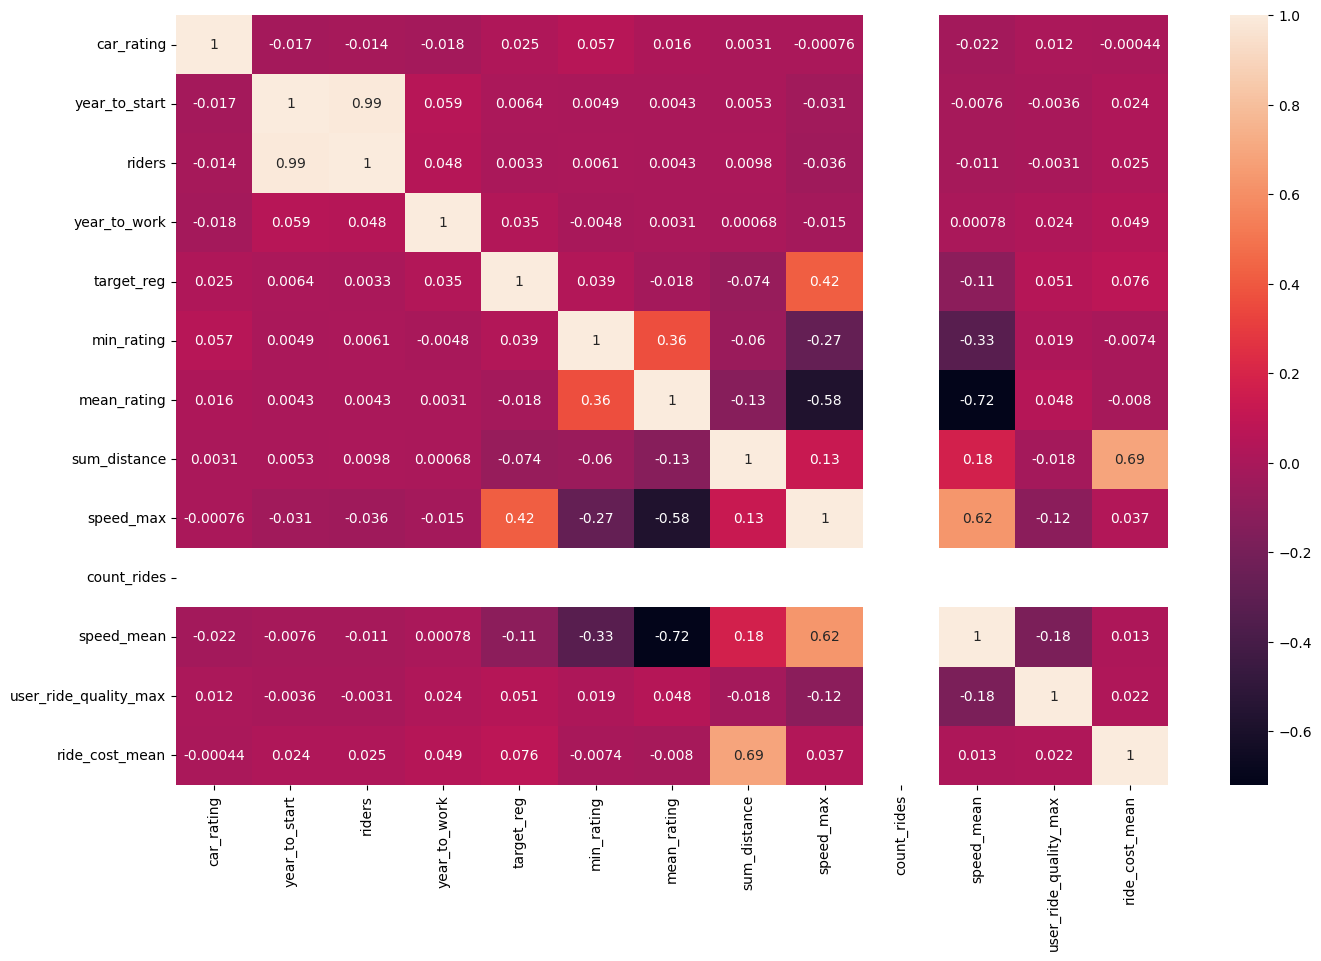

In [38]:
plt.figure(figsize=(16, 10))
sns.heatmap(df.corr(), annot=True)
plt.show();

### Phik

In [17]:
!pip install phik

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 10.2 MB/s eta 0:00:00


In [39]:
import phik
from phik import report

In [40]:
phik_matrix = df.phik_matrix()

interval columns not set, guessing: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'min_rating', 'mean_rating', 'sum_distance', 'speed_max', 'count_rides', 'speed_mean', 'user_ride_quality_max', 'ride_cost_mean']


/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable car_id is large: 2337. Are you sure this is not an interval variable? Analysis for pairs of variables including car_id can be slow.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable count_rides for analysis 1. Dropping this column
  warnings.warn(


In [41]:
print(phik_matrix)

                       car_id     model  car_type  fuel_type  car_rating  \
car_id                    1.0  1.000000  1.000000   1.000000    1.000000   
model                     1.0  1.000000  1.000000   1.000000    0.000000   
car_type                  1.0  1.000000  1.000000   0.692853    0.000000   
fuel_type                 1.0  1.000000  0.692853   1.000000    0.000000   
car_rating                1.0  0.000000  0.000000   0.000000    1.000000   
year_to_start             1.0  0.552224  0.272381   0.000000    0.052272   
riders                    1.0  0.510233  0.296849   0.000000    0.096036   
year_to_work              1.0  0.183417  0.103821   0.000000    0.015231   
target_reg                1.0  0.344664  0.205868   0.396224    0.000000   
target_class              1.0  0.171317  0.182602   0.000000    0.000000   
min_rating                1.0  0.079759  0.000000   0.093780    0.127178   
mean_rating               1.0  0.125587  0.078749   0.000000    0.066677   
sum_distance

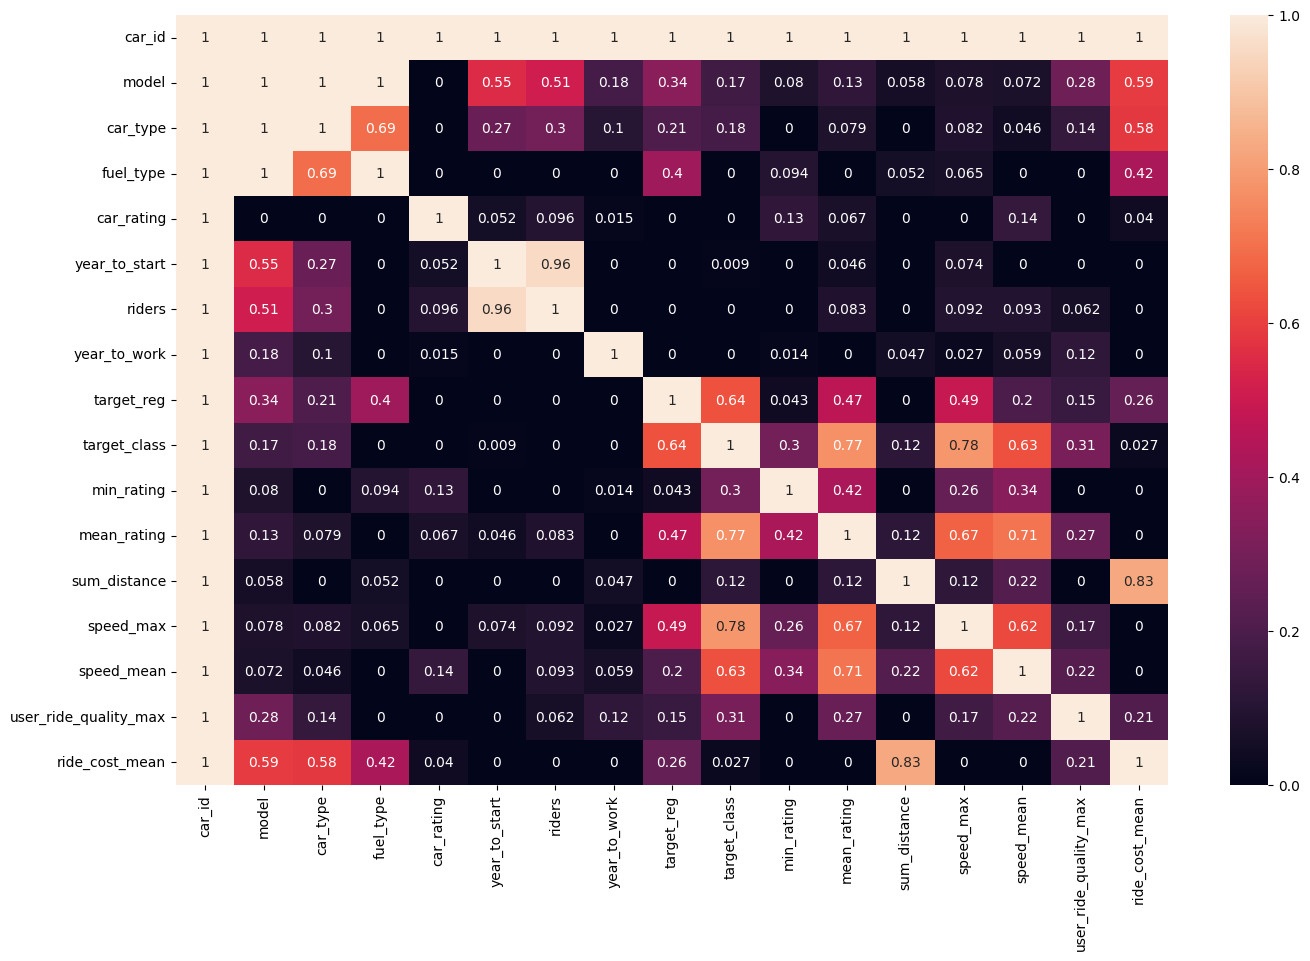

In [45]:
plt.figure(figsize=(16, 10))
sns.heatmap(phik_matrix, annot=True)
plt.show();

### Permutation importance

In [17]:
# Нужна обученная модель, возьму для обучения решающее дерево
from sklearn.ensemble import RandomForestClassifier

In [18]:
df.head()

,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,min_rating,mean_rating,speed_max,speed_mean
0,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,0.1,4.737759,180.855726,44.660920
1,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,0.0,4.480517,187.862734,49.862069
2,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,0.1,4.768391,102.382857,44.005747
3,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,0.1,3.880920,172.793237,49.344828
4,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,0.1,4.181149,203.462289,50.603448


In [19]:
df['model'].unique()

array(['Kia Rio X-line', 'VW Polo VI', 'Renault Sandero',
       'Mercedes-Benz GLC', 'Skoda Rapid', 'Nissan Qashqai',
       'Tesla Model 3', 'Kia Sportage', 'Smart ForFour', 'VW Polo',
       'Kia Rio', 'Smart Coupe', 'VW Tiguan', 'Smart ForTwo', 'Kia Rio X',
       'Mercedes-Benz E200', 'Renault Kaptur', 'Mini Cooper',
       'Hyundai Solaris', 'Volkswagen ID.4 ', 'Fiat 500', 'BMW 320i',
       'Audi A4', 'Audi Q3', 'Audi A3', 'MINI CooperSE'], dtype=object)

In [20]:
df['fuel_type'].unique()

array(['petrol', 'electro'], dtype=object)

In [21]:
!pip install category_encoders

In [22]:
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce

ohe = OneHotEncoder(sparse=False)
be = ce.BinaryEncoder()

categorical_cols = df.select_dtypes(include=['object']).columns

In [23]:
categorical_cols

Index(['model', 'car_type', 'fuel_type', 'target_class'], dtype='object')

In [24]:
for col in categorical_cols:
    if df[col].nunique() <= 2:
      print(col)

fuel_type


In [25]:
categorical_cols

Index(['model', 'car_type', 'fuel_type', 'target_class'], dtype='object')

Для столбцов, где больше 2 уникальных значений применяю BinaryEncoding, а для тех, где меньше или равно, то One-Hot Encoding

In [26]:
for col in categorical_cols:
    if df[col].nunique() <= 2:
        transformed = ohe.fit_transform(df[[col]])
        transformed_df = pd.DataFrame(transformed, columns=[col+'_'+str(i) for i in range(transformed.shape[1])])
        df = df.join(transformed_df)
        df = df.drop(col, axis=1)

categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    transformed = be.fit_transform(df[[col]])
    transformed_df = pd.DataFrame(transformed, columns=[col+'_'+str(i) for i in range(transformed.shape[1])])
    df = df.join(transformed_df)
    df = df.drop(col, axis=1)

df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,car_rating,year_to_start,riders,year_to_work,target_reg,min_rating,mean_rating,speed_max,speed_mean,fuel_type_0,...,model_2,model_3,model_4,car_type_0,car_type_1,car_type_2,target_class_0,target_class_1,target_class_2,target_class_3
0,3.78,2015,76163,2021,108.53,0.1,4.737759,180.855726,44.660920,0.0,...,0,0,1,0,0,1,0,0,0,1
1,3.90,2015,78218,2021,35.20,0.0,4.480517,187.862734,49.862069,0.0,...,0,1,0,0,0,1,0,0,1,0
2,6.30,2012,23340,2017,38.62,0.1,4.768391,102.382857,44.005747,0.0,...,0,1,1,0,1,0,0,0,1,1
3,4.04,2011,1263,2020,30.34,0.1,3.880920,172.793237,49.344828,0.0,...,1,0,0,0,1,1,0,1,0,0
4,4.70,2012,26428,2017,30.45,0.1,4.181149,203.462289,50.603448,0.0,...,0,1,1,0,1,0,0,1,0,0


#### К сожалению, у меня очень долго считался permutation_importance, поэтому я удалю несколько столбцов для ускорения и демонстрации того, что я всё же воспользовался permutation_importance

In [27]:
cols_for_delete = ['fuel_type_1',
                   'model_0',
                   'model_1',
                   'model_2',
                   'model_3',
                   'model_4',
                   'car_type_0',
                   'car_type_1',
                   'car_type_2',
                   'target_class_0',
                   'target_class_1',
                   'target_class_2',
                   'target_class_3'
]

In [28]:
df.drop(columns=cols_for_delete)

,car_rating,year_to_start,riders,year_to_work,target_reg,min_rating,mean_rating,speed_max,speed_mean,fuel_type_0
0,3.78,2015,76163,2021,108.53,0.10,4.737759,180.855726,44.660920,0.0
1,3.90,2015,78218,2021,35.20,0.00,4.480517,187.862734,49.862069,0.0
2,6.30,2012,23340,2017,38.62,0.10,4.768391,102.382857,44.005747,0.0
3,4.04,2011,1263,2020,30.34,0.10,3.880920,172.793237,49.344828,0.0
4,4.70,2012,26428,2017,30.45,0.10,4.181149,203.462289,50.603448,0.0
...,...,...,...,...,...,...,...,...,...,...
2332,4.38,2017,121239,2018,25.48,0.10,4.608908,141.502350,44.488506,0.0
2333,4.30,2016,107793,2020,69.26,0.10,4.683793,155.000000,45.879310,0.0
2334,3.88,2015,80234,2019,46.03,0.10,4.655345,104.180940,45.339080,0.0
2335,4.50,2014,60048,2020,77.19,0.10,4.638333,200.000000,43.563218,0.0


In [29]:
model = RandomForestClassifier().fit(df.drop('riders', axis=1), df['riders'])

In [30]:
from sklearn.inspection import permutation_importance

In [31]:
res = permutation_importance(model, df.drop('riders', axis=1), df['riders'], n_repeats=10)

In [32]:
res_sorted_idx = res.importances_mean.argsort()

In [38]:
res_sorted_idx_flip = np.flip(res_sorted_idx)

#### Визуализация

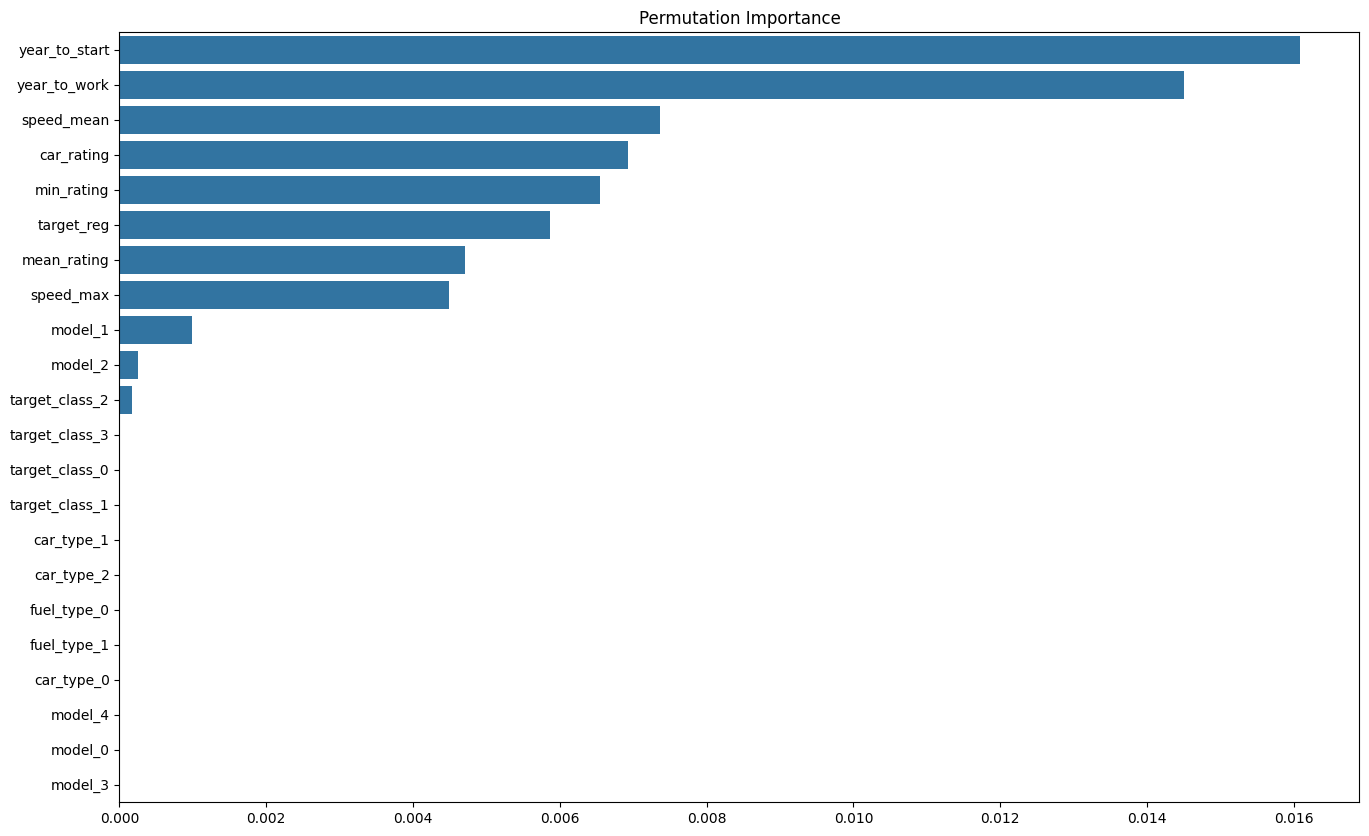

In [39]:
fig, ax = plt.subplots(figsize=(16, 10))
sns.barplot(x=res.importances_mean[res_sorted_idx_flip], y=np.array(df.drop('riders', axis=1).columns)[res_sorted_idx_flip], orient='h', ax=ax)
ax.set_title('Permutation Importance')
plt.show();

# Домашнее задание 2. Прогноз времени и вида поломки машин. Настройка ML-модели

<div class="alert alert-info">

**Цель блока** — составить тренировочную и валидационную выборки, произвести обучение модели `CatBoostClassifier` на тренировочной части и оценить качество на валидационной.

##Обучение первой модели (5 баллов)

1.   Новый пункт
2.   Новый пункт



1. Классифицируйте признаки на типы (категориальные, числовые, таргеты).

2. Выделите в `X` только признаки, а в `Y` — таргет (для задачи классификации).

3. Сделайте разделение данных на *обучающую* и *валидационную* выборки (не забывайте про воспроизводимость результатов).

4. Создайте и обучите `CatBoostClassifier` модель (настраивать гиперпараметры сейчас не обязательно).

5. Проведите оценку вашей модели, используя метрику `accuracy`.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.

</div>

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
features2drop = [...] # то, что надо выбросить
targets = [...] # таргеты
cat_features = [...] # категориальные признаки

num_features = [...] # числовые признаки

print('Категориальные признаки:', len(cat_features), cat_features)
print('Числовые признаки:', len(num_features), num_features)
print('Целевые переменные', targets)

In [ ]:
# YOUR CODE HERE

# Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков

<div class="alert alert-info">

**Цель блока** — визуализировать результаты прогнозирования, ошибки модели и важность признаков для лучшего понимания и анализа модели.

## Визуализация (5 баллов)

   
1. Визуализируйте важность признаков встроенным методом в `CatBoost`  (помните, что не стоит сильно доверять этому рейтингу важности, т. к. для сильно скоррелированных признаков важность делится пополам — оба признака могут улететь вниз).

2. Постройте `waterfall_plot` из библиотеки `SHAP` (подробнее во втором ноутбуке из полезных ссылок ниже).
    
3. Постройте `classification_report` из библиотеки `scikit-learn`.

4. Постройте и визуализируйте матрицу смежности (`confusion_matrix`), посмотрите, в каких классах модель больше всего ошибается.
    
5. Для каждого графика/примененного метода проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.
    
</div>

<div class="alert alert-success">

Визуализация может помочь даже после того, как мы **уже обучили** какую-нибудь модель. Например:

- Понять, что мешает модели или чего не хватает, чтобы не допускать ошибки.
- Сделать выводы, как можно улучшить точность в последующих экспериментах.
- Визуализировать ошибки модели.
- Отсеять лишние признаки.
- Найти идеи для новых признаков.
- Все зависит от типа ваших данных.

<h3> Полезные источники </h3>
    
- Занятие про визуализацию и Seaborn.
- Занятие про продвинутую визуализацию и анализ ошибок модели.

</div>    

In [ ]:
# YOUR CODE HERE

# Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, произведя подбор гиперпараметров для модели с помощью `Optuna`.

## Подбор гиперпараметров (3 балла)

1. Напишите `objective` функцию и запустите `Optuna`.
2. Подберите гиперпараметры для `CatBoostClassifier` (минимум 3).
3. Обучите модель с новыми гиперпараметрами, сравните качество и сделайте выводы.

    
<h4> Критерии оценивания </h4>
    
- 1 балл за каждый корректно выполненный пункт.
    
</div>

In [ ]:
# YOUR CODE HERE

### Общая информация по `Optuna`

#### Ключевые особенности <code>Optuna</code>



- Легковесность и универсальность — можно подбирать оптимальные параметры под любые функции и метрики.
- SOTA-алгоритмы, адаптированные для поиска гиперпараметров.
- Параллелизация и различные методы прунинга.
- Встроенная визуализация.
- Интеграция со множеством популярных библиотек (бустинги, sklearn, PyTorch, W&B и другие).

Разберем Optuna по частям, чтобы понять, как ее использовать.

#### <code>Study</code>: оптимизация, базирующаяся на <code>Objective</code> функции



В `Objective`-функцию нужно написать код подсчета метрики, которую возвращаем. `Objective` вызывается Optuna много раз для подбора лучших параметров.
```python
def objective(trial, ...):
    # calculate score...
    return score
```

<h4> <code>Trial</code> — одно выполнение <code>Objective</code>-функции</h4>

В `trial`-объекте мы передаем параметры для «перебора», используя для каждого типа свой метод. Например:

```python
# метод `suggest_float` показывает, что перебираем `float` значения, от 0 и до 1.5 границы
param = trial.suggest_float('param', 0, 1.5)

# Категориальное значение
loss_function = trial.suggest_categorical('loss', ['Logloss', 'CrossEntropy'])

# Целочисленное значение
depth = trial.suggest_int('depth', 5, 8)

# Равномерное распределение
learning_rate = trial.suggest_uniform('learning_rate', 0.0, 1.0)
```

#### `Study` parameters

Инициализируем объект `study`, который начнет перебор и сохранит в себе историю результатов.
Если мы стараемся увеличить метрику, а не уменьшить ошибку, то используем `create_study(direction='maximize')`.
```python
study = optuna.create_study()
study.optimize(objective, n_trials=10)
```

<div class="alert alert-info">
    
В [`Optuna`](https://optuna.readthedocs.io/en/stable/index.html) реализовано несколько методов (`sampler`) подбора параметров (в том числе классические):
* `GridSampler`
* `RandomSampler`
* `Tree-Structed Parzen Estimator` (`TPESampler` — самый популярный, дефолтный)
* `BruteForceSampler`
* [Другие 4 метода](https://optuna.readthedocs.io/en/stable/reference/samplers/index.html#module-optuna.samplers) (можно написать собственный семплер)

### Советы по перебору параметров

- Иметь понимание важности параметров.
- Число `iterations` лучше взять с запасом и зафиксировать, при этом ограничив через `early_stopping_rounds`.
- Подсмотреть или чувствовать диапазоны и шаг значений.
- Исключить то, что перебирать не нужно (`random_seed` , `eval_metric`, `thread_count` и прочее).
- Используйте информацию с прошлых попыток.

# Домашнее задание 4. Блендинг

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, объединив несколько моделей вместе методом блендинга.

## Задание 6. Блендинг (10 баллов)

1. Построить и обучить модели:
    - `CatBoostClassifier`,
    - `LightGBMClassifier (goss)`,
    - `XGBoostClassifier (dart)`,
    - `RandomForestClassifier`.
2. Сделать предсказания каждой моделью, оценить качество.
3. Реализовать блендинг двумя способами, оценить качество и сравнить с предыдущим пунктом:
    - `Hard Voting` —  метод, при котором делаем голосование всех моделей и выбираем самый популярный класс.
    - `Soft Voting` —  метод, при котором мы складываем вероятности предсказания всех моделей по каждому классу и потом выбираем самый класс с максимальной суммой.
    
<h4> Критерии оценивания </h4>
    
- Обучены 4 модели — 1 балл за каждую обученную модель, всего 4 балла.
- Для модели проведен подбор гиперпараметров — 0,5 балла за каждый параметр, всего 2 балла.
- Сделаны предсказания каждой модели и оценено качество — 1 балл.
- Реализован `Hard Voting` — 1 балл.
- Реализован `Soft Voting` — 1 балл.
- Сделаны выводы — 1 балл.
    
</div>

In [ ]:
# YOUR CODE HERE

### Общая информация о блендинге

**Основная идея** — взять от каждого алгоритма лучшее и совместить несколько разных ML-моделей в одну.

Что это дает:
- Увеличивается обобщающая способность финальной модели и качество улучшается.
- Модель становится более стабильной, что позволяет не слететь на приватном лидерборде.

Особенно хорошо накидывает блендинг, если смешиваемые модели имеют разную природу — например, нейронные сети, kNN и решающие деревья. Они выучивают разные зависимости и хорошо дополняют друг друга.

</div>

# <center id="part6"> Отправка финального решения на лидерборд на Kaggle

<div class="alert alert-info">

**Цель блока** — сделать предсказание с помощью блендинга для тестовой части датасета, отправить результат [в соревнование на Kaggle](https://www.kaggle.com/competitions/competative-data-science-course-by-data-feeling/overview).

## Задание 8. Предсказание на тестовом датасете и отправка на Kaggle

1. Сделать предобработку для тестового датасета, присоединить к нему информацию из других датасетов и добавить признаки, которые генерировали для тренировочного датасета.
2. Сделать предсказания каждой моделью, которую хотите включить в ансамбль, но минимум их должно быть 3.
3. Сделать блендинг с помощью `Hard Voting` или `Soft Voting` на ваш выбор.
4. Сохранить результат предсказания в `csv` файл и отправить решение на Kaggle.
    
<h4> Критерии оценивания </h4>
    
- 0 баллов за задание, если итоговый скор на лидерборде меньше чем `0.9`.
- 1 балл за каждый выполненный пункт.

</div>

In [ ]:
car_test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_test.csv')
car_test.head(3)

In [ ]:
# YOUR CODE HERE

### Советы по отправке кода на Kaggle



Если пишете код на `Kaggle`, то для отправки решения:

1. Нажать Save Version.
2. Проверить, что в Advanced Settings выбрано «Всегда сохранять результаты ноутбука».
3. Выбрать тип сохранения Save & Run All (Commit).
4. Нажать кнопку Save.